Import necessary modules and have a look at the data 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/Users/sakshamgrover/Codes/newcode/MLEXAMPLES/Life_Expectancy.csv')

print(df.describe())
print(df.columns.tolist())
print(df.isnull().sum())


Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
Infant deaths                        0
Alcohol                            194
Percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
Under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
Thinness  1-19 years                34
Thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64


Preprocessing:
Year, and Country are removed as they are not needed due to either having too many nulls and/or not contributing enough to the problem statement which is to see the effect on life expectancy by multiple features where country and year don't matter in this case



In [2]:
columns_to_drop = [col for col in ['Country', 'Year'] if col in df.columns]
df = df.drop(columns=columns_to_drop)
print(df.columns.tolist())

['Status', 'Life expectancy', 'Adult Mortality', 'Infant deaths', 'Alcohol', 'Percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness  1-19 years', 'Thinness 5-9 years', 'Income composition of resources', 'Schooling']


Now we define variables and remove nulls from the target feature and split the vars

In [3]:
df = df.dropna(subset=['Life expectancy'])
target = 'Life expectancy'
X = df.drop(columns=[target])
y = df['Life expectancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


For appropriate scaling and transformations the skewness should be checked to apply scaling and transformations if needed

In [11]:
from scipy.stats import skew
numeric_columns = df.select_dtypes(include='number').columns
skew_values = df[numeric_columns].skew()

print(skew_values.sort_values(ascending=False))


Population                         15.909653
Infant deaths                       9.771044
Under-five deaths                   9.479623
Measles                             9.425290
HIV/AIDS                            5.386623
Percentage expenditure              4.643790
GDP                                 3.202781
Thinness 5-9 years                  1.776591
Thinness  1-19 years                1.710626
Adult Mortality                     1.174369
Alcohol                             0.587276
Total expenditure                   0.577233
BMI                                -0.230559
Schooling                          -0.583884
Life expectancy                    -0.638605
Income composition of resources    -1.142142
Hepatitis B                        -1.933774
Diphtheria                         -2.072601
Polio                              -2.097958
dtype: float64


The skewness is high in some variables. Overall, the data should be scaled so that the features are normalized to avoid weightage in the model so all features contribute at the same scale. To finish preprocessing of data the pipeline is made where nulls in numerical variables will be imputed using the median values (as some are skewed so average may not be as reliable to use) and will also be scaled to put data on the same weightage. the categorical values will be one hot encoded and the nulls will be imputed with the most frequently occuring values. 

In [4]:
numerical_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])


Since there are also many features that may correlate with each other such as GDP, population, total expenditure.. under 5 deaths, infant mortality.. thinness, bmi and so on. To mitigate this, ridge regression is used to penalize colinear coefficients so that a more uniform result is achieved. gridsearch cv is used alongside to cross validate and find the best alpha value to use for ridge regression


In [ ]:
from sklearn.linear_model import Ridge

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

#alpha values for gridsearch CV to check 
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100]
}
#run gridsearch
gridsearch = GridSearchCV(pipeline,param_grid, cv=5, scoring='neg_mean_squared_error')
gridsearch.fit(X_train, y_train)

estimator = gridsearch.best_estimator_
y_pred = estimator.predict(X_test)

print(" Best alpha:", gridsearch.best_params_['regressor__alpha'])
print(" Test MSE:", mean_squared_error(y_test, y_pred))
print(" Test R2:", r2_score(y_test, y_pred))


 Best alpha: 0.1
 Test MSE: 15.622589973307763
 Test R2: 0.8193907754989074


Plotting the findings:

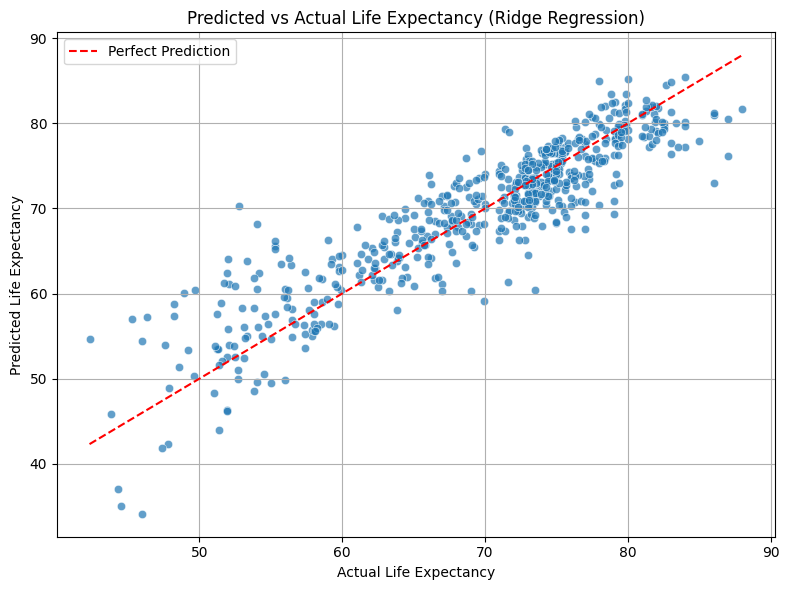

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predicted vs Actual plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Predicted vs Actual Life Expectancy (Ridge Regression)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

R2 is good, indicating that the fit of the y_pred line is relatively good. MSE is also relatively fine. An improvement for the model might be to scale the data a bit better by using log transforms or other similar methods. Now to plot feature importances to get the feature coefficients and to what degree they affect the life expectancy

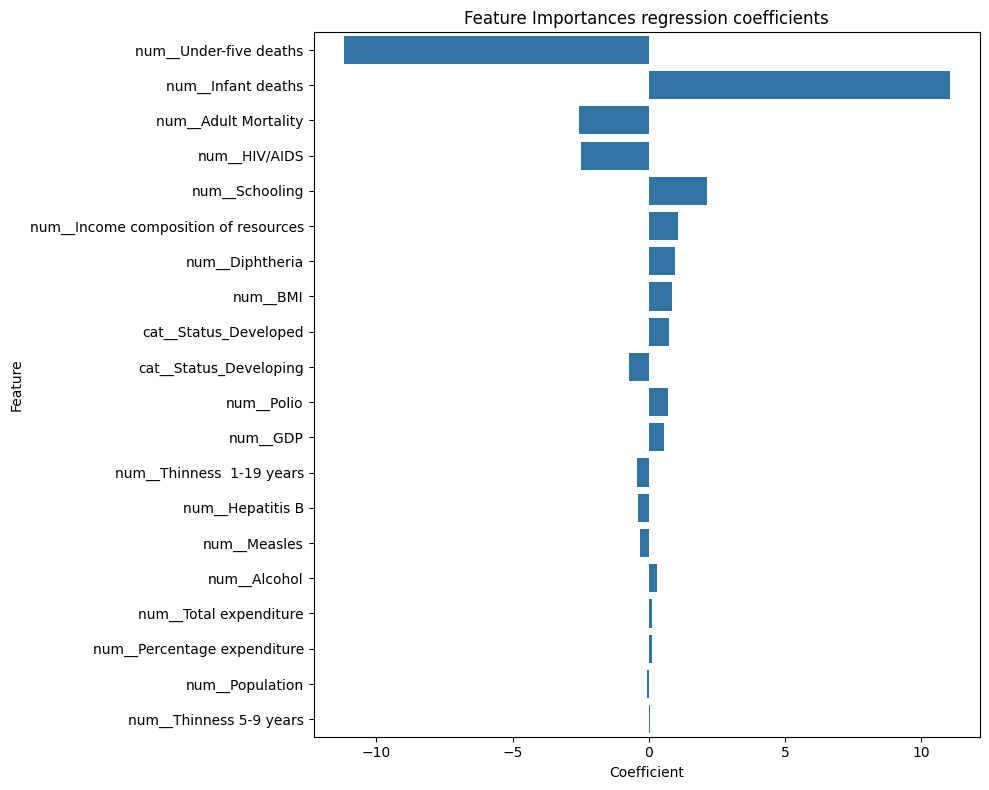

In [ ]:
feature_names = estimator.named_steps['preprocessor'].get_feature_names_out()
coefficients = estimator.named_steps['regressor'].coef_

#feature importance seperate dataframe making, after extraction of feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

importance_df['abs_coef'] = importance_df['Coefficient'].abs()
importance_df_sorted = importance_df.sort_values('abs_coef', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_df_sorted.head(22))
plt.title("Feature Importances regression coefficients")
plt.tight_layout()
plt.show()


1. Does various predicting factors really affect the Life expectancy?
- There are a few factors that affect life expectancy mainly so there are various that affect it. 

2. What are the predicting variables actually affecting the life expectancy?
- Infant and under five deaths and adult mortality, makes sense as its a direct effect due to people dying earlier.

3. Should a country having a lower life expectancy value increase its healthcare expenditure in order to improve its average lifespan?
    Healthcare expenditure does not affect the life expectancy as much as shown in the graph in "total expenditure" 

4. Do Infant and Adult mortality rates affect life expectancy?
- Infant and adult mortality rates are the biggest factors affecting life expectancy

5. Does Life Expectancy has positive or negative correlation with a country's status (developing or developed), lifestyle, GDP, etc.
- Developing has negative correlation with life expectancy and developed has positive as shown. Interpretability may be affected due to correlations between features but it makes sense statistically. 

6. What is the impact of schooling on the lifespan of humans?
- Schooling is one of the biggest factors in affecting the lifespan of humans, which makes it significant impact on lifespan. 

7. Does Life Expectancy have positive or negative relationship with drinking alcohol?
- Alcohol is a minor impact but not negligible on life expectancy, it can be seen having positive coeff although due to correlation it may be positive, though it should be negative.

8. What is the impact of Immunization coverage (for various disease like Measles,Hepatitis B) on life Expectancy?
- Immunization coverage as a whole has a significant impact on life expectancy with HIV/AIDS having the biggest impact. Due to correlation others may be smaller and/or have positive effects but overall immunization coverage will significantly impact life expectancy positively. 